In [3]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

%matplotlib inline

In [4]:
asteroid_data = pd.read_csv("nasa.csv")
print(asteroid_data)

      Neo Reference ID     Name  Absolute Magnitude  Est Dia in KM(min)  \
0              3703080  3703080              21.600            0.127220   
1              3723955  3723955              21.300            0.146068   
2              2446862  2446862              20.300            0.231502   
3              3092506  3092506              27.400            0.008801   
4              3514799  3514799              21.600            0.127220   
...                ...      ...                 ...                 ...   
4682           3759007  3759007              23.900            0.044112   
4683           3759295  3759295              28.200            0.006089   
4684           3759714  3759714              22.700            0.076658   
4685           3759720  3759720              21.800            0.116026   
4686           3772978  3772978              19.109            0.400641   

      Est Dia in KM(max)  Est Dia in M(min)  Est Dia in M(max)  \
0               0.284472         

In [5]:
label_encoder = LabelEncoder()
text_columns = ['Orbiting Body', 'Equinox']

for col in text_columns:
    asteroid_data[col] = label_encoder.fit_transform(asteroid_data[col])

Обучите модель случайного леса (Random Forest). Рассчитайте точность.

In [6]:
X = asteroid_data.drop(columns=['Neo Reference ID', 'Orbit ID', 'Name', 'Close Approach Date', 'Epoch Date Close Approach', 'Orbit Determination Date', 'Hazardous'])

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = asteroid_data['Hazardous']

print(f'Количество колонок: {X.shape[1]}')

Количество колонок: 33


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

accuracy = accuracy_score(y_test, rf_classifier.predict(X_test))
print("Точность модели Random Forest без PCA:", accuracy)

Точность модели Random Forest без PCA: 0.997867803837953


Сократите количество параметров датасета одним из способов Feature Selection, например, параметры с низкой дисперсией.

In [8]:
selector = VarianceThreshold(threshold=0.01)
X_train_selected = selector.fit_transform(X_train)
X_test_selected = selector.transform(X_test)

print("Количество признаков после удаления с низкой дисперсией:", X_train_selected.shape[1])

Количество признаков после удаления с низкой дисперсией: 22


На сокращенном датасете обучите модель случайного леса (Random Forest). Рассчитайте точность.

In [9]:
rf_classifier_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_selected.fit(X_train_selected, y_train)

accuracy_selected = accuracy_score(y_test, rf_classifier_selected.predict(X_test_selected))
print("Точность модели Random Forest с выбранными признаками:", accuracy_selected)

Точность модели Random Forest с выбранными признаками: 0.9968017057569296


К исходному (большому) датасету примените метод PCA, найдите 2 главные компоненты.

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print("Дисперсия каждой главной компоненты:", pca.explained_variance_ratio_)
print("Новый размер датасета после применения PCA:", X_pca.shape)

Дисперсия каждой главной компоненты: [0.35995563 0.11903061]
Новый размер датасета после применения PCA: (4687, 2)


Визуализируйте данные по этим двум компонентам.

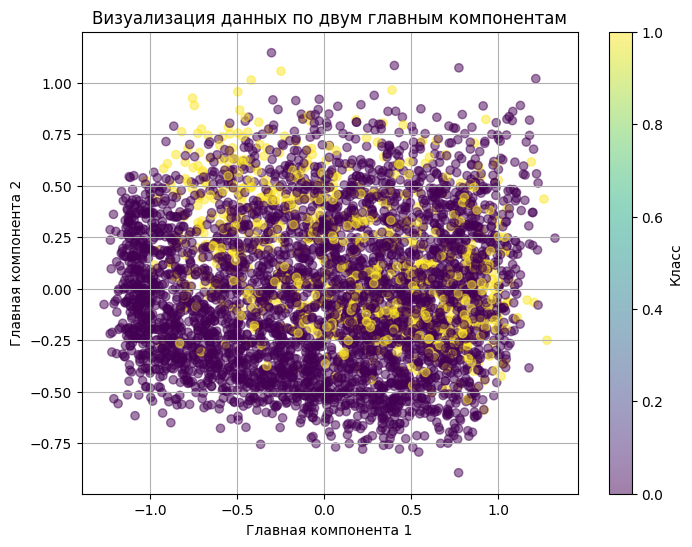

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.title('Визуализация данных по двум главным компонентам')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.colorbar(label='Класс')
plt.grid(True)
plt.show()

Обучите модель случайного леса на полученной модели PCA с двумя компонентами. Оцените точность и время

In [12]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

start_time = time.time()
rf_classifier_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_pca.fit(X_train_pca, y_train)
training_time = time.time() - start_time

accuracy_pca = accuracy_score(y_test, rf_classifier_pca.predict(X_test_pca))

print("Точность модели Random Forest с PCA (2 компоненты):", accuracy_pca)
print("Время обучения модели:", training_time, "секунд")

Точность модели Random Forest с PCA (2 компоненты): 0.8336886993603412
Время обучения модели: 0.6469175815582275 секунд


Из графика зависимости отклонения модели от количества главных компонент найдите такое количество главных компонент, чтобы оставить 90% дисперсии исходных данных.

Количество главных компонент для объяснения 90% дисперсии: 6
Дисперсия при использовании 6 главных компонент: 0.906871449557908


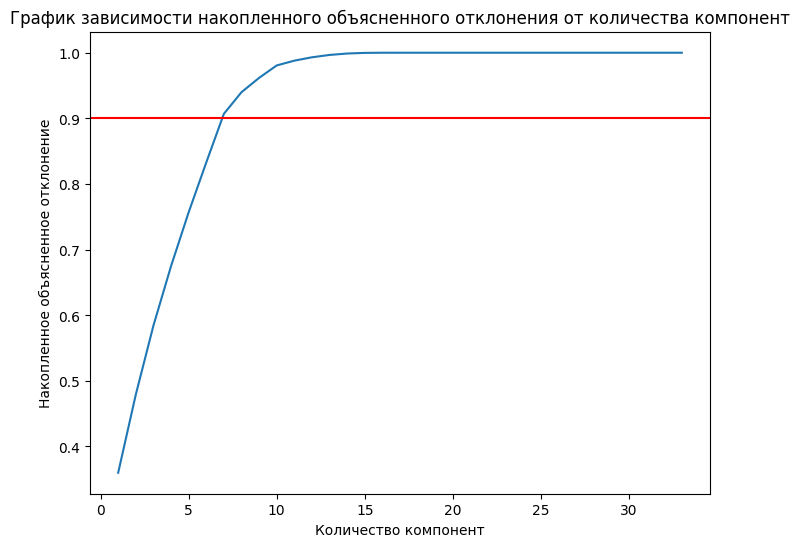

In [18]:
pca = PCA()
pca.fit(X)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

n_components_90_variance = np.argmax(cumulative_variance_ratio >= 0.90)
explained_variance_90 = cumulative_variance_ratio[n_components_90_variance]

print("Количество главных компонент для объяснения 90% дисперсии:", n_components_90_variance)
print("Дисперсия при использовании", n_components_90_variance, "главных компонент:", explained_variance_90)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Количество компонент')
plt.ylabel('Накопленное объясненное отклонение')
plt.title('График зависимости накопленного объясненного отклонения от количества компонент')
plt.axhline(y=0.9, color='r')
plt.show()


In [19]:
pca_one_component = PCA(n_components=6)
X_pca_one_component = pca_one_component.fit_transform(X)

X_train_pca_one_component, X_test_pca_one_component, _, _ = train_test_split(X_pca_one_component, y, test_size=0.2, random_state=42)
rf_classifier_pca_one_component = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_pca_one_component.fit(X_train_pca_one_component, y_train)

accuracy_pca_one_component = accuracy_score(y_test, rf_classifier_pca_one_component.predict(X_test_pca_one_component))
print("Точность модели Random Forest с 6 главными компонентами:", accuracy_pca_one_component)

Точность модели Random Forest с 6 главными компонентами: 0.8688699360341151
